
# Modelo de Condição de Casco com Dados IWS, AIS, Eventos e Consumo 🚢🧠

Este notebook implementa um fluxo **supervisionado** completo usando:

- **Relatórios IWS** (`Relatorios IWS (1).xlsx`) → condição real do casco (target)
- **AIS histórico** (`Dados_AIS.xlsx`) → base de treino
- **AIS NAVIO TESTE 2/3** (`AIS_NAVIO TESTE 2 1.csv`, `AIS_NAVIO TESTE 3 1.csv`) → navios de teste
- **Eventos + Consumo** (`Eventos_Validacao 1.CSV`, `Consumo_Validacao 1.CSV`) → features operacionais extras
- **Planilha de validação** (`RESULTADO Validação 1.xlsx`) → onde serão preenchidas as previsões

Fluxo geral:

1. Carregar todos os dados
2. Normalizar nomes das embarcações (`shipKey`)
3. Criar features de AIS (velocidade, rumo, posição, nº de registros)
4. Criar features de eventos e consumo (por navio)
5. Unir tudo com os relatórios IWS para montar a base de treino
6. Treinar um **RandomForestRegressor**
7. Aplicar o modelo na planilha `RESULTADO Validação 1.xlsx`, incluindo **NAVIO TESTE 2** e **NAVIO TESTE 3**
8. Exportar um novo arquivo Excel com a coluna **“Condição do casco”** preenchida.


In [1]:

import pandas as pd
import numpy as np
import unicodedata
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

base_dir = Path(".")
print("Pasta base:", base_dir.resolve())


Pasta base: C:\Users\Karlinhos\Downloads\Modelo Classificação


## Carregando todos os arquivos

In [4]:

path_iws       = base_dir / "Relatorios IWS (1).xlsx"
path_ais_train = base_dir / "Dados_AIS.xlsx"
path_evt       = base_dir / "Eventos_Validacao 1.CSV"
path_cons      = base_dir / "Consumo_Validacao 1.CSV"
path_navios    = base_dir / "Dados navios Validação 1.xlsx"
path_result    = base_dir / "RESULTADO Validação 1.xlsx"
path_ais_t2    = base_dir / "AIS_NAVIO TESTE 2 1.csv"
path_ais_t3    = base_dir / "AIS_NAVIO TESTE 3 1.csv"

for p in [path_iws, path_ais_train, path_evt, path_cons, path_navios, path_result, path_ais_t2, path_ais_t3]:
    print(p.name, "->", "OK" if p.exists() else "NÃO ENCONTRADO")

# leitura
df_iws       = pd.read_excel(path_iws, sheet_name="dados_inc")
df_ais_train = pd.read_excel(path_ais_train, sheet_name="Dados_AIS")
df_evt       = pd.read_csv(path_evt)
df_cons      = pd.read_csv(path_cons)
df_navios    = pd.read_excel(path_navios)
df_result    = pd.read_excel(path_result, header=1)
df_ais_t2    = pd.read_csv(path_ais_t2)
df_ais_t3    = pd.read_csv(path_ais_t3)

print("\nIWS:")
display(df_iws.head())
print("\nAIS treino:")
display(df_ais_train.head())
print("\nEventos:")
display(df_evt.head())
print("\nConsumo:")
display(df_cons.head())
print("\nResultado validação (alvo a preencher):")
display(df_result.head())


Relatorios IWS (1).xlsx -> OK
Dados_AIS.xlsx -> OK
Eventos_Validacao 1.CSV -> OK
Consumo_Validacao 1.CSV -> OK
Dados navios Validação 1.xlsx -> OK
RESULTADO Validação 1.xlsx -> OK
AIS_NAVIO TESTE 2 1.csv -> OK
AIS_NAVIO TESTE 3 1.csv -> OK

IWS:


,Classe,Embarcação,Sigla,Data,Local de realização,Regiões do casco limpas,Condição geral da embarcação,Tipo de incrustação da embarcação,Condição do fundo chato,Tipo de incrustação do fundo chato,Condição do costado,Tipo de incrustação do costado,Condição do hélice,Tipo de incrustação do hélice
0,Aframax,Carla Silva,CSI,2025-08-29 00:00:00,Angra dos Reis/RJ,NaN,1,"Craca, alga e limo",1,Incrustações duras e moles,"100%, 20%",Moles (100%) e Duras (20%),1,Moles e Duras
1,Suezmax,Raul Martins,RMA,2023-03-30 00:00:00,São Sebastião/SP,NaN,0.1,Duras no fundo,0.1,Duras,Não consta no relatório,Não consta no relatório,0.4,Moles e Duras
2,MR2,Eduardo Costa,EDC,2025-01-11 00:00:00,São Sebastião/SP,NaN,0.1,Moles e duras,0.1,Moles (5%) e Duras (5%),0.05,Moles,0.8,Moles
3,Suezmax,Victor Oliveira,VOL,2021-03-03 00:00:00,Salvador/BA,NaN,0.3,Cracas e limo,0.3,Cracas e limo,0.3,Cracas e limo,0.9,Cracas e limo
4,Aframax,Carla Silva,CSI,2021-08-21 00:00:00,Angra dos Reis/RJ,NaN,1,Alga e limo,1,Alga e limo,1,Alga e limo,0.85,"Alga, limo e calcárea"



AIS treino:


,NOME,DATA,HORA,RUMO,VELOCIDADE,LATITUDE,LONGITUDE
0,BRUNO LIMA,2023-11-25 05:58:41,05:58:41,58.1,12.2,-24.954948,-46.857981
1,BRUNO LIMA,2023-11-25 06:04:02,06:04:02,58.5,12.2,-24.946165,-46.840565
2,BRUNO LIMA,2023-11-25 06:26:12,06:26:12,59.2,12.1,-24.910048,-46.768348
3,BRUNO LIMA,2023-11-25 06:57:31,06:57:31,69.1,12.3,-24.860081,-46.665115
4,BRUNO LIMA,2023-11-25 07:46:41,07:46:41,62.9,12.2,-24.777231,-46.506615



Eventos:


,sessionId,shipName,class,eventName,startGMTDate,endGMTDate,duration,distance,aftDraft,fwdDraft,midDraft,TRIM,displacement,beaufortScale,seaCondition,beaufortScaleDesc,seaConditionDesc,speed,speedGps,Porto,decLatitude,decLongitude
0,40200000209,NAVIO TESTE 3,Aframax,EM PORTO,26/08/2021 01:00,26/08/2021 02:30,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40200000214,NAVIO TESTE 3,Aframax,EM PORTO,26/08/2021 02:30,26/08/2021 13:40,11.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40200000216,NAVIO TESTE 3,Aframax,EM PORTO,26/08/2021 13:40,26/08/2021 13:55,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40200000218,NAVIO TESTE 3,Aframax,NAVEGACAO,26/08/2021 13:55,26/08/2021 15:55,2.00,9.0,9.0,5.5,7.25,3.5,50847.21,NaN,NaN,3 - Gentle breeze,3 - Slight,4.5,4.5,NaN,NaN,NaN
4,40200000220,NAVIO TESTE 3,Aframax,EM PORTO,26/08/2021 15:55,26/08/2021 17:00,1.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Consumo:


,SESSION_ID,CONSUMED_QUANTITY,DESCRIPTION
0,40200000214,NaN,LSHFO 0.5
1,40200000214,NaN,LSMGO 0.5
2,40200000218,2.0,LSHFO 0.5
3,40200000218,NaN,LSMGO 0.5
4,40200000227,NaN,LSHFO 0.5



Resultado validação (alvo a preencher):


,Embarcação,Data Avaliada,Condição do casco
0,DANIEL PEREIRA,2025-05-27,NaN
1,VICTOR OLIVEIRA,2025-04-12,NaN
2,GABRIELA MARTINS,2025-05-13,NaN
3,HENRIQUE ALVES,2025-05-14,NaN
4,CARLA SILVA,2025-04-12,NaN


## Normalização dos nomes das embarcações (`shipKey`)

In [5]:

def normalize_name(name):
    if pd.isna(name):
        return None
    s = str(name).upper()
    s = ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
    return s.strip()

# aplica shipKey nos dataframes relevantes
df_iws['shipKey']       = df_iws['Embarcação'].map(normalize_name)
df_ais_train['shipKey'] = df_ais_train['NOME'].map(normalize_name)
df_evt['shipKey']       = df_evt['shipName'].map(normalize_name)
df_cons['shipKey']      = df_cons['SHIP_NAME'].map(normalize_name) if 'SHIP_NAME' in df_cons.columns else np.nan
df_navios['shipKey']    = df_navios['Nome do navio'].map(normalize_name)
df_result['shipKey']    = df_result['Embarcação'].map(normalize_name)
df_ais_t2['shipKey']    = df_ais_t2['NOME'].map(normalize_name)
df_ais_t3['shipKey']    = df_ais_t3['NOME'].map(normalize_name)

print("Exemplo shipKey IWS:")
display(df_iws[['Embarcação','shipKey']].head())


Exemplo shipKey IWS:


,Embarcação,shipKey
0,Carla Silva,CARLA SILVA
1,Raul Martins,RAUL MARTINS
2,Eduardo Costa,EDUARDO COSTA
3,Victor Oliveira,VICTOR OLIVEIRA
4,Carla Silva,CARLA SILVA


## Preparando base IWS (condição real do casco)

In [6]:

# garantir datetime e pegar o relatório mais recente por navio
df_iws['Data'] = pd.to_datetime(df_iws['Data'], errors='coerce')
df_iws_sorted = df_iws.sort_values(['shipKey', 'Data'])
df_iws_latest = df_iws_sorted.drop_duplicates(subset=['shipKey'], keep='last')

# alvo numérico: Condição geral da embarcação
df_iws_latest['condicao_casco'] = pd.to_numeric(
    df_iws_latest['Condição geral da embarcação'],
    errors='coerce'
)

# remover casos sem alvo numérico (ex: 'Não avaliado', '70-80%')
df_iws_train = df_iws_latest[~df_iws_latest['condicao_casco'].isna()].copy()

print("Registros IWS para treino (após limpeza):", df_iws_train.shape)
display(df_iws_train[['Embarcação','Data','Condição geral da embarcação','condicao_casco']].head(10))


Registros IWS para treino (após limpeza): (15, 16)


C:\Users\Karlinhos\AppData\Local\Temp\ipykernel_1352\2327847026.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iws_latest['condicao_casco'] = pd.to_numeric(


,Embarcação,Data,Condição geral da embarcação,condicao_casco
16,Bruno Lima,2024-05-08,0.6,0.60
15,Carla Silva,2025-10-10,2,2.00
6,Daniel Pereira,2021-01-18,0.2,0.20
2,Eduardo Costa,2025-01-11,0.1,0.10
17,Fábio Santos,2024-08-10,0,0.00
9,Felipe Ribeiro,2022-12-31,0.8,0.80
5,Giselle Carvalho,2023-01-10,0.1,0.10
13,Marcos Cavalcanti,2024-01-28,0.05,0.05
18,Maria Valentina,2024-11-04,0,0.00
21,Rafael Santos,2025-08-23,0.8,0.80


## Criando features de AIS (treino e navios teste)

In [7]:

def build_ais_features(df, ship_col='shipKey'):
    d = df.copy()
    # garante numérico
    for c in ['VELOCIDADE', 'RUMO', 'LATITUDE', 'LONGITUDE']:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors='coerce')
    if ship_col != 'shipKey':
        d['shipKey'] = d[ship_col]
    g = d.groupby('shipKey').agg({
        'VELOCIDADE': ['mean','max','std'],
        'RUMO': ['mean','std'],
        'LATITUDE': ['mean','std'],
        'LONGITUDE': ['mean','std'],
    })
    g.columns = ['_'.join(col).strip() for col in g.columns.values]
    g['n_registros'] = d.groupby('shipKey')['VELOCIDADE'].size()
    return g.reset_index()

feat_ais_train = build_ais_features(df_ais_train, ship_col='shipKey')
feat_ais_t2    = build_ais_features(df_ais_t2, ship_col='shipKey')
feat_ais_t3    = build_ais_features(df_ais_t3, ship_col='shipKey')

print("Features AIS treino:", feat_ais_train.shape)
display(feat_ais_train.head())
print("\nFeatures AIS NAVIO TESTE 2:", feat_ais_t2.shape)
display(feat_ais_t2.head())
print("\nFeatures AIS NAVIO TESTE 3:", feat_ais_t3.shape)
display(feat_ais_t3.head())


Features AIS treino: (20, 11)


,shipKey,VELOCIDADE_mean,VELOCIDADE_max,VELOCIDADE_std,RUMO_mean,RUMO_std,LATITUDE_mean,LATITUDE_std,LONGITUDE_mean,LONGITUDE_std,n_registros
0,BRUNO LIMA,9.455719,33.8,4.891257,176.004424,104.813691,-8.577940,9.258829,-41.660149,5.825032,25338
1,CARLA SILVA,6.223277,14.7,5.607703,175.528790,102.939471,-24.306439,3.180859,-44.682653,3.125521,10865
2,DANIEL PEREIRA,10.876000,15.0,4.429032,165.958888,104.645370,-13.355151,10.522381,-40.900127,4.695024,13529
3,EDUARDO COSTA,9.736412,18.8,4.736179,161.535590,101.987788,-12.595242,9.624905,-41.322670,5.758973,19826
4,FABIO SANTOS,10.596048,31.0,4.371641,180.624504,101.430135,-5.759900,6.318846,-41.304149,6.127928,40609



Features AIS NAVIO TESTE 2: (1, 11)


,shipKey,VELOCIDADE_mean,VELOCIDADE_max,VELOCIDADE_std,RUMO_mean,RUMO_std,LATITUDE_mean,LATITUDE_std,LONGITUDE_mean,LONGITUDE_std,n_registros
0,NAVIO TESTE 2,9.809349,15.2,5.041536,157.159359,102.232654,-21.36726,6.44308,-41.530019,4.814667,14761



Features AIS NAVIO TESTE 3: (1, 11)


,shipKey,VELOCIDADE_mean,VELOCIDADE_max,VELOCIDADE_std,RUMO_mean,RUMO_std,LATITUDE_mean,LATITUDE_std,LONGITUDE_mean,LONGITUDE_std,n_registros
0,NAVIO TESTE 3,5.331752,12.5,4.414045,170.256305,104.84604,-22.08469,3.697354,-43.684422,3.314178,18336


## Criando features de eventos e consumo por navio

In [10]:
df_evt.columns


Index(['sessionId', 'shipName', 'class', 'eventName', 'startGMTDate', 'endGMTDate', 'duration', 'distance', 'aftDraft', 'fwdDraft',
       'midDraft', 'TRIM', 'displacement', 'beaufortScale', 'seaCondition', 'beaufortScaleDesc', 'seaConditionDesc', 'speed', 'speedGps',
       'Porto', 'decLatitude', 'decLongitude', 'shipKey', 'startGMTDate_dt', 'endGMTDate_dt'],
      dtype='object')

In [11]:
df_cons.columns

Index(['SESSION_ID', 'CONSUMED_QUANTITY', 'DESCRIPTION', 'shipKey'], dtype='object')

In [13]:

# Conversões de datas e numéricos em eventos e consumo
def parse_datetime_br(col):
    return pd.to_datetime(col, format='%d/%m/%Y %H:%M', errors='coerce')

# Eventos
if 'startGMTDate' in df_evt.columns and 'endGMTDate' in df_evt.columns:
    df_evt['startGMTDate_dt'] = parse_datetime_br(df_evt['startGMTDate'])
    df_evt['endGMTDate_dt']   = parse_datetime_br(df_evt['endGMTDate'])
if 'speedGps' in df_evt.columns:
    df_evt['speedGps'] = pd.to_numeric(df_evt['speedGps'], errors='coerce')
if 'duration' in df_evt.columns:
    df_evt['duration'] = pd.to_numeric(df_evt['duration'], errors='coerce')
if 'distance' in df_evt.columns:
    df_evt['distance'] = pd.to_numeric(df_evt['distance'], errors='coerce')

# Consumo
if 'CONSUMED_QUANTITY' in df_cons.columns:
    df_cons['CONSUMED_QUANTITY'] = pd.to_numeric(df_cons['CONSUMED_QUANTITY'], errors='coerce')

def build_event_features(df_evt: pd.DataFrame) -> pd.DataFrame:
    # agrega por shipKey (navio)
    agg_num = df_evt.groupby('shipKey').agg({
        'duration': ['mean', 'sum'],
        'distance': ['mean', 'sum'],
        'speedGps': ['mean', 'max'],
    })
    agg_num.columns = ['_'.join(col).strip() for col in agg_num.columns.values]

    # proporção do tempo por tipo de evento
    pivot_evt = df_evt.pivot_table(
        index='shipKey',
        columns='eventName',
        values='duration',
        aggfunc='sum',
        fill_value=0
    )
    total_duration = pivot_evt.sum(axis=1).replace(0, np.nan)
    prop_evt = pivot_evt.divide(total_duration, axis=0)
    prop_evt = prop_evt.add_prefix('prop_dur_')

    features_evt = pd.concat([agg_num, prop_evt], axis=1).reset_index()
    return features_evt

# --- Normalizando shipKey em ambos os DataFrames (ESSENCIAL) ---

df_evt['shipKey']  = df_evt['shipKey'].astype(str).str.strip()
df_cons['shipKey'] = df_cons['shipKey'].astype(str).str.strip()


def build_consumption_features(df_evt: pd.DataFrame, df_cons: pd.DataFrame) -> pd.DataFrame:

    # Correção aplicando shipKey como string para evitar erro de dtype
    df_evt['shipKey']  = df_evt['shipKey'].astype(str).str.strip()
    df_cons['shipKey'] = df_cons['shipKey'].astype(str).str.strip()
    
    # Soma de combustível por tipo / navio
    df_merged = df_evt.merge(
        df_cons[['shipKey','DESCRIPTION','CONSUMED_QUANTITY']],
        on='shipKey',
        how='left'
    )
    
    pivot_fuel = (
        df_merged
        .groupby(['shipKey','DESCRIPTION'])['CONSUMED_QUANTITY']
        .sum()
        .unstack(fill_value=0)
    )

    return pivot_fuel.add_prefix('fuel_').reset_index()


feat_evt  = build_event_features(df_evt)
feat_cons = build_consumption_features(df_evt, df_cons)

print("Features de eventos:", feat_evt.shape)
display(feat_evt.head())
print("\nFeatures de consumo:", feat_cons.shape)
display(feat_cons.head())


Features de eventos: (2, 10)


,shipKey,duration_mean,duration_sum,distance_mean,distance_sum,speedGps_mean,speedGps_max,prop_dur_DOCAGEM,prop_dur_EM PORTO,prop_dur_NAVEGACAO
0,NAVIO TESTE 2,16.101262,32395.74,181.966611,205622.27,10.161743,217.33,0.020023,0.406256,0.573721
1,NAVIO TESTE 3,14.272430,33183.40,51.640247,46011.46,7.640067,32.67,0.017247,0.837514,0.145239



Features de consumo: (0, 1)


DESCRIPTION,shipKey


## Montando base de treino (IWS + AIS + eventos + consumo)

In [20]:

# começa dos relatórios IWS (df_iws_train) e junta features
df_train = (
    df_iws_train
    .merge(feat_ais_train, on='shipKey', how='left')
    .merge(feat_evt,      on='shipKey', how='left')
    .merge(feat_cons,     on='shipKey', how='left')
)

print("Base de treino após merges:", df_train.shape)
display(df_train.head())

# seleciona colunas de features numéricas (exclui textos/identificadores)
exclude_cols = [
    'Classe', 'Embarcação', 'Sigla', 'Local de realização',
    'Regiões do casco limpas', 'Condição geral da embarcação',
    'Tipo de incrustação da embarcação', 'Condição do fundo chato',
    'Tipo de incrustação do fundo chato', 'Condição do bojo',
    'Tipo de incrustação do bojo', 'Condição do costado',
    'Tipo de incrustação do costado', 'Condição do intake',
    'Tipo de incrustação do intake', 'Condição das áreas de borda',
    'Tipo de incrustação das áreas de borda', 'Condição dos apêndices',
    'Tipo de incrustação dos apêndices', 'Condição do hélice',
    'Tipo de incrustação do hélice', 'shipKey', 'Data'
]

feature_cols = [
    c for c in df_train.columns
    if c not in exclude_cols
    and c not in ['condicao_casco']   # 🔥 impedir que o alvo vire feature
    and df_train[c].dtype != 'O'
]


print("Qtd de features numéricas:", len(feature_cols))


Base de treino após merges: (15, 35)


,Classe,Embarcação,Sigla,Data,Local de realização,Regiões do casco limpas,Condição geral da embarcação,Tipo de incrustação da embarcação,Condição do fundo chato,Tipo de incrustação do fundo chato,Condição do costado,Tipo de incrustação do costado,Condição do hélice,Tipo de incrustação do hélice,shipKey,condicao_casco,VELOCIDADE_mean,VELOCIDADE_max,VELOCIDADE_std,RUMO_mean,RUMO_std,LATITUDE_mean,LATITUDE_std,LONGITUDE_mean,LONGITUDE_std,n_registros,duration_mean,duration_sum,distance_mean,distance_sum,speedGps_mean,speedGps_max,prop_dur_DOCAGEM,prop_dur_EM PORTO,prop_dur_NAVEGACAO
0,Gaseiros 7k,Bruno Lima,BRL,2024-05-08,Ipojuca/PE,NaN,0.6,Cracas e limo,0.6,Cracas e limo,0.6,Cracas e limo,0.6,Cracas e calcárea,BRUNO LIMA,0.6,9.455719,33.8,4.891257,176.004424,104.813691,-8.577940,9.258829,-41.660149,5.825032,25338.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aframax,Carla Silva,CSI,2025-10-10,Angra dos Reis/RJ,NaN,2,NORMAN,3,NORMAN,2,NORMAN,Não avaliado,Não avaliado,CARLA SILVA,2.0,6.223277,14.7,5.607703,175.528790,102.939471,-24.306439,3.180859,-44.682653,3.125521,10865.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aframax,Daniel Pereira,DAP,2021-01-18,Salvador/BA,NaN,0.2,"Craca, alga e limo",0.2,"Craca, alga e limo",0.2,"Craca, alga e limo",0.7,"Craca, alga e limo",DANIEL PEREIRA,0.2,10.876000,15.0,4.429032,165.958888,104.645370,-13.355151,10.522381,-40.900127,4.695024,13529.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MR2,Eduardo Costa,EDC,2025-01-11,São Sebastião/SP,NaN,0.1,Moles e duras,0.1,Moles (5%) e Duras (5%),0.05,Moles,0.8,Moles,EDUARDO COSTA,0.1,9.736412,18.8,4.736179,161.535590,101.987788,-12.595242,9.624905,-41.322670,5.758973,19826.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gaseiros 7k,Fábio Santos,FSA,2024-08-10,Fortaleza/CE,NaN,0,NaN,0,NaN,0,NaN,0,NaN,FABIO SANTOS,0.0,10.596048,31.0,4.371641,180.624504,101.430135,-5.759900,6.318846,-41.304149,6.127928,40609.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Qtd de features numéricas: 19


## Treinando modelo Random Forest

In [21]:

X = df_train[feature_cols].fillna(0)
y = df_train['condicao_casco']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=1  # n_jobs=1 para evitar problemas de multiprocessing em alguns ambientes
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
r2  = r2_score(y_val, y_pred)

print(f"MAE validação: {mae:.4f}")
print(f"R² validação:  {r2:.4f}")


MAE validação: 0.3028
R² validação:  -3.5560


## Criando base de features para predição (planilha de validação)

In [22]:

# junta AIS (treino + navios teste)
feat_ais_t2t3 = pd.concat([feat_ais_t2, feat_ais_t3], ignore_index=True)
feat_ais_all  = pd.concat([feat_ais_train, feat_ais_t2t3], ignore_index=True)
feat_ais_all  = feat_ais_all.drop_duplicates(subset=['shipKey'], keep='last')

# eventos/consumo já estão em feat_evt/feat_cons (navios da validação)

df_feat_all = (
    df_result[['Embarcação','Data Avaliada','shipKey']]
    .merge(feat_ais_all, on='shipKey', how='left')
    .merge(feat_evt,     on='shipKey', how='left')
    .merge(feat_cons,    on='shipKey', how='left')
)

print("Base de features para predição:", df_feat_all.shape)
display(df_feat_all.head())


Base de features para predição: (13, 22)


,Embarcação,Data Avaliada,shipKey,VELOCIDADE_mean,VELOCIDADE_max,VELOCIDADE_std,RUMO_mean,RUMO_std,LATITUDE_mean,LATITUDE_std,LONGITUDE_mean,LONGITUDE_std,n_registros,duration_mean,duration_sum,distance_mean,distance_sum,speedGps_mean,speedGps_max,prop_dur_DOCAGEM,prop_dur_EM PORTO,prop_dur_NAVEGACAO
0,DANIEL PEREIRA,2025-05-27,DANIEL PEREIRA,10.876000,15.0,4.429032,165.958888,104.645370,-13.355151,10.522381,-40.900127,4.695024,13529.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,VICTOR OLIVEIRA,2025-04-12,VICTOR OLIVEIRA,8.939557,16.7,5.792231,170.835825,101.870937,-19.634722,9.059995,-42.107617,4.281787,25262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GABRIELA MARTINS,2025-05-13,GABRIELA MARTINS,11.167140,16.3,4.504937,173.182112,95.305531,-14.560664,10.258811,-41.012079,4.465401,5350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HENRIQUE ALVES,2025-05-14,HENRIQUE ALVES,9.162067,16.0,5.175266,160.097300,105.980008,-22.934167,5.909498,-42.423385,4.525518,13703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CARLA SILVA,2025-04-12,CARLA SILVA,6.223277,14.7,5.607703,175.528790,102.939471,-24.306439,3.180859,-44.682653,3.125521,10865.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Aplicando o modelo na planilha de validação

In [23]:

# usar as mesmas colunas de features do treino, quando existirem na base de predição
pred_feature_cols = [c for c in feature_cols if c in df_feat_all.columns]

X_pred = df_feat_all[pred_feature_cols].fillna(0)
df_feat_all['Condição do casco_pred'] = rf.predict(X_pred)

display(df_feat_all[['Embarcação','Data Avaliada','Condição do casco_pred']].head(20))


,Embarcação,Data Avaliada,Condição do casco_pred
0,DANIEL PEREIRA,2025-05-27,0.291333
1,VICTOR OLIVEIRA,2025-04-12,0.366167
2,GABRIELA MARTINS,2025-05-13,0.521667
3,HENRIQUE ALVES,2025-05-14,0.402833
4,CARLA SILVA,2025-04-12,1.402667
5,NAVIO TESTE 2,2024-08-01,0.245667
6,NAVIO TESTE 2,2025-04-18,0.245667
7,NAVIO TESTE 3,2025-06-01,1.139667
8,NaN,NaT,1.181333
9,NaN,NaT,1.181333


## Preenchendo `RESULTADO Validação` e salvando arquivo final

In [24]:

df_out = df_result.copy()

df_merge = df_out.merge(
    df_feat_all[['Embarcação','Data Avaliada','Condição do casco_pred']],
    on=['Embarcação','Data Avaliada'],
    how='left'
)

cond_col = 'Condição do casco'
mask_nan = df_merge[cond_col].isna()
df_merge.loc[mask_nan, cond_col] = df_merge.loc[mask_nan, 'Condição do casco_pred']

print("Amostra do resultado final:")
display(df_merge.head(20))

output_path = base_dir / "RESULTADO_Validacao_com_previsoes_COMPLETO.xlsx"
df_merge.to_excel(output_path, index=False)
print("Arquivo salvo em:", output_path.resolve())


Amostra do resultado final:


,Embarcação,Data Avaliada,Condição do casco,shipKey,Condição do casco_pred
0,DANIEL PEREIRA,2025-05-27,0.291333,DANIEL PEREIRA,0.291333
1,VICTOR OLIVEIRA,2025-04-12,0.366167,VICTOR OLIVEIRA,0.366167
2,GABRIELA MARTINS,2025-05-13,0.521667,GABRIELA MARTINS,0.521667
3,HENRIQUE ALVES,2025-05-14,0.402833,HENRIQUE ALVES,0.402833
4,CARLA SILVA,2025-04-12,1.402667,CARLA SILVA,1.402667
5,NAVIO TESTE 2,2024-08-01,0.245667,NAVIO TESTE 2,0.245667
6,NAVIO TESTE 2,2025-04-18,0.245667,NAVIO TESTE 2,0.245667
7,NAVIO TESTE 3,2025-06-01,1.139667,NAVIO TESTE 3,1.139667
8,NaN,NaT,1.181333,None,1.181333
9,NaN,NaT,1.181333,None,1.181333


Arquivo salvo em: C:\Users\Karlinhos\Downloads\Modelo Classificação\RESULTADO_Validacao_com_previsoes_COMPLETO.xlsx


## Visualização rápida das previsões por embarcação (opcional)

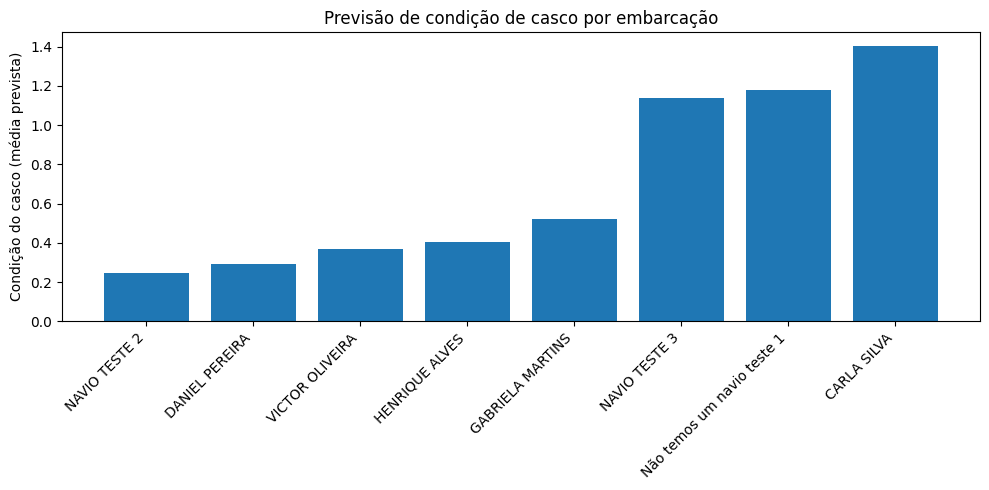

In [25]:

import matplotlib.pyplot as plt

tmp = df_merge.copy()
tmp = tmp.dropna(subset=['Condição do casco'])
tmp_group = tmp.groupby('Embarcação')['Condição do casco'].mean().sort_values()

plt.figure(figsize=(10,5))
plt.bar(tmp_group.index.astype(str), tmp_group.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Condição do casco (média prevista)')
plt.title('Previsão de condição de casco por embarcação')
plt.tight_layout()
plt.show()


In [26]:
# Criar faixas para classificador
df_train_clean = df_train.copy()
df_train_clean['classe_casco'] = pd.cut(
    df_train_clean['condicao_casco'],
    bins=[0, 33, 66, 100],
    labels=['LIMPO','MÉDIO','SUJO'],
    include_lowest=True
)


In [27]:
from sklearn.ensemble import RandomForestClassifier

Xc = df_train_clean[feature_cols].fillna(0)
yc = df_train_clean['classe_casco']

Xc_train, Xc_val, yc_train, yc_val = train_test_split(Xc, yc, test_size=0.25, random_state=42)

clf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

clf.fit(Xc_train, yc_train)
pred_clf = clf.predict(Xc_val)

from sklearn.metrics import accuracy_score, classification_report
print("ACURÁCIA CLASSIFICAÇÃO:", accuracy_score(yc_val, pred_clf))
print("\nRELATÓRIO CLASSIFICAÇÃO:\n", classification_report(yc_val, pred_clf))


ACURÁCIA CLASSIFICAÇÃO: 1.0

RELATÓRIO CLASSIFICAÇÃO:
               precision    recall  f1-score   support

       LIMPO       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [32]:
df_feat_all['casco_norm'] = df_feat_all['Condição do casco_pred'] * 100

In [41]:
df_feat_all['classe_pred'] = pd.cut(
    df_feat_all['casco_norm'],
    bins=[0, 33, 66, 100],
    labels=['LIMPO','MÉDIO','SUJO'],
    include_lowest=True
)


In [38]:
df_feat_all['classe_pred'] = pd.cut(
    df_feat_all['casco_norm'],
    bins=[0, 33, 66, 300],   # aceita até 300% se surgir
    labels=['LIMPO','MÉDIO','SUJO'],
    include_lowest=True
)


In [40]:
def classificar_avancado(valor):
    if valor < 25:
        return "LIMPO 🟢"
    elif valor < 50:
        return "LEVE 🟡"
    elif valor < 75:
        return "MÉDIO 🟠"
    elif valor < 100:
        return "SEVERO 🔴"
    else:
        return "CRÍTICO ⚫"

df_feat_all['classe_avancada'] = df_feat_all['casco_norm'].apply(classificar_avancado)

display(df_feat_all[['Embarcação','Data Avaliada','casco_norm','classe_avancada']])


,Embarcação,Data Avaliada,casco_norm,classe_avancada
0,DANIEL PEREIRA,2025-05-27,29.133333,LEVE 🟡
1,VICTOR OLIVEIRA,2025-04-12,36.616667,LEVE 🟡
2,GABRIELA MARTINS,2025-05-13,52.166667,MÉDIO 🟠
3,HENRIQUE ALVES,2025-05-14,40.283333,LEVE 🟡
4,CARLA SILVA,2025-04-12,140.266667,CRÍTICO ⚫
5,NAVIO TESTE 2,2024-08-01,24.566667,LIMPO 🟢
6,NAVIO TESTE 2,2025-04-18,24.566667,LIMPO 🟢
7,NAVIO TESTE 3,2025-06-01,113.966667,CRÍTICO ⚫
8,NaN,NaT,118.133333,CRÍTICO ⚫
9,NaN,NaT,118.133333,CRÍTICO ⚫
